# IEEE European Low Voltage Test Feeder: 

http://sites.ieee.org/pes-testfeeders/resources/

The current IEEE test cases are focused on North American style systems; however it is common outside of North America to see low-voltage distribution systems, both radial and meshed. It is important to make sure that tools support both dominant styles of distribution system configuration. This test case seeks to fill a benchmark gap by presenting a number of common low-voltage configurations. This circuit also introduces quasi-static time series simulations.

IEEE European LV network is a generic 0.416 kV network serviced by one 0.8 MVA MV/LV transformer and a 11kV external grid. The network supplies 906 LV buses and 55 1-PH loads. The network layout is mostly radial

The final network looks like this:

<img src="pics/IEEE_european_lv_grid.png" width="70%">

# Time Series data from Benchmark dataset
In this example the time series data from benchmark is used to perform a time series load flow analysis
in pandapower

The network data from csv is used to create Powerfactory and pandapower networks.

The Sum total of power and maximum voltage is plotted with respect to 1440 time steps( 1 min interval) during the day:



# Pre-requisites :
- Load data from IEEE benchmark dataset
- pandapower network of IEEE European LV


In [1]:
import os
import numpy as np
import pandas as pd
import tempfile
import pandapower as pp
from pandapower import pp_dir
from pandapower.control import ConstControl
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.networks import ieee_european_lv_asymmetric

parent = pp_dir
path = parent + "\\European_LV_CSV\\"
load_path = path + "\\Load Profiles\\"
def remove_comments(f):
    '''Pass comments'''
    start=f.seek(0)
    for index in range(5):
        start=f.tell()
        if f.readline().startswith('#'):
            continue
        else:
            break      
    f.seek(start)
    return f

with open (path+"Loads.csv",'r') as f:
    f = remove_comments(f)
    loads = pd.read_csv(f)
    f.close()
    
with open (path+"LoadShapes.csv",'r') as f:
    f = remove_comments(f)
    loadshapes = pd.read_csv(f)
    f.close()

In [2]:
print('\n Load data\n',loads.head(5),'\n Load Shape Files\n', loadshapes.head(5))


 Load data
     Name  numPhases  Bus phases    kV  Model Connection  kW    PF   Yearly
0  LOAD1          1   34      A  0.23      1        wye   1  0.95  Shape_1
1  LOAD2          1   47      B  0.23      1        wye   1  0.95  Shape_2
2  LOAD3          1   70      A  0.23      1        wye   1  0.95  Shape_3
3  LOAD4          1   73      A  0.23      1        wye   1  0.95  Shape_4
4  LOAD5          1   74      A  0.23      1        wye   1  0.95  Shape_5 
 Load Shape Files
       Name  npts  minterval                File  useactual
0  Shape_1  1440          1  Load_profile_1.csv       True
1  Shape_2  1440          1  Load_profile_2.csv       True
2  Shape_3  1440          1  Load_profile_3.csv       True
3  Shape_4  1440          1  Load_profile_4.csv       True
4  Shape_5  1440          1  Load_profile_5.csv       True



# time series

Function to load time series data and perform time-series **three phase load flow**

In [3]:
def timeseries_example(output_dir):
    # 1. create  net from pandapower networks
    net = ieee_european_lv_asymmetric()
    # 2. laods data source from IEEE benchmark data
    profiles, ds = create_data_source()
    # 3. create controllers (to control P, Q values of the load and the sgen)
    net = create_controllers(net, ds)

    # time steps taken from load shape file
    time_steps = range(0, loadshapes.npts[0])

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir)

    # 5. Run time series function
    run_timeseries(net, time_steps, output_writer=ow, run=pp.runpp_3ph,continue_on_divergence=True)

# Data source
Data taken from csv data provided in IEEE benchmark grid

In [4]:
def create_data_source():
    profiles = pd.DataFrame()
    for loadprofile,file in (loadshapes[['Name','File']].values):
        profiles[loadprofile] = pd.read_csv(load_path+file).mult.values*1e-3 
        profiles[loadprofile+'cos_phi'] = float(loads[loads.Yearly==loadprofile].PF.values)
    ds = DFData(profiles)
    return profiles, ds

# Time series controller
P, Q values entered using P and power factor(cos_phi) data

In [5]:
def create_controllers(net, ds):
    ConstControl(net, element='asymmetric_load', variable='p_a_mw', element_index=loads[loads['phases']=='A'].index,
                 data_source=ds, profile_name=loads[loads['phases']=='A'].Yearly)
    ConstControl(net, element='asymmetric_load', variable='p_b_mw', element_index=loads[loads['phases']=='B'].index,
                 data_source=ds, profile_name=loads[loads['phases']=='B'].Yearly)
    ConstControl(net, element='asymmetric_load', variable='p_c_mw', element_index=loads[loads['phases']=='C'].index,
                 data_source=ds, profile_name=loads[loads['phases']=='C'].Yearly)
    ConstControl(net, element='asymmetric_load', variable='cos_phi', element_index=loads.index,
                 data_source=ds, profile_name=loads.Yearly+'cos_phi', set_q_from_cosphi_3ph=True)    
    return net

# Format output
- Maximum bus voltage magnitude for each time step
- Aggregated Sum of P & Q values for each time step

In [6]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xls")
    ow.log_variable('res_bus_3ph', 'p_a_mw', index=net.bus.index, eval_function=np.sum, eval_name="bus_sum_pa")
    ow.log_variable('res_bus_3ph', 'p_b_mw', index=net.bus.index, eval_function=np.sum, eval_name="bus_sum_pb")
    ow.log_variable('res_bus_3ph', 'p_c_mw', index=net.bus.index, eval_function=np.sum, eval_name="bus_sum_pc")
    ow.log_variable('res_bus_3ph', 'q_a_mvar', index=net.bus.index, eval_function=np.sum, eval_name="bus_sum_qa")
    ow.log_variable('res_bus_3ph', 'q_b_mvar', index=net.bus.index, eval_function=np.sum, eval_name="bus_sum_qb")
    ow.log_variable('res_bus_3ph', 'q_c_mvar', index=net.bus.index, eval_function=np.sum, eval_name="bus_sum_qc")
    ow.log_variable('res_bus_3ph', 'vm_a_pu', index=net.bus.index, eval_function=np.max, eval_name="bus_max_va")
    ow.log_variable('res_bus_3ph', 'vm_b_pu', index=net.bus.index, eval_function=np.max, eval_name="bus_max_vb")
    ow.log_variable('res_bus_3ph', 'vm_c_pu', index=net.bus.index, eval_function=np.max, eval_name="bus_max_vc")
    return ow

# Main Function

In [8]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

Results can be found in your local temp folder: C:\Users\uk067483\AppData\Local\Temp\time_series_example
Progress: |█████████████████████████████████████████████-----| 90.2% Complete

hp.pandapower.timeseries.run_time_series - ERROR: LoadflowNotConverged at time step 1298


Progress: |██████████████████████████████████████████████████| 100.0% Complete



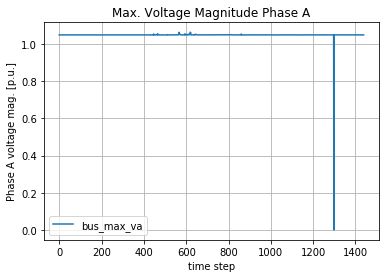

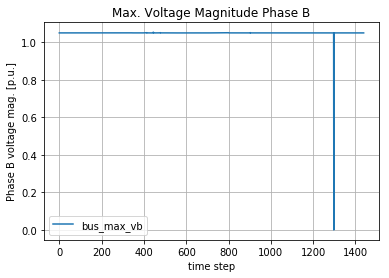

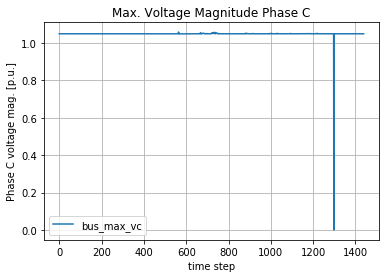

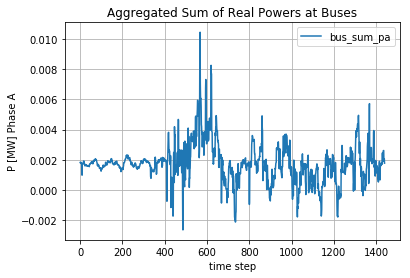

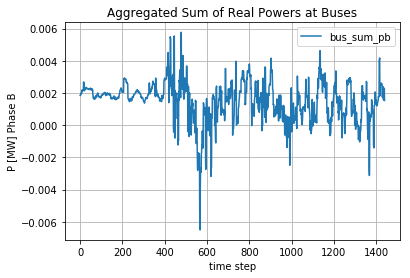

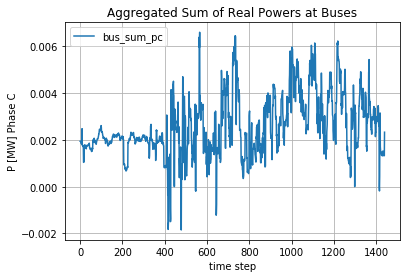

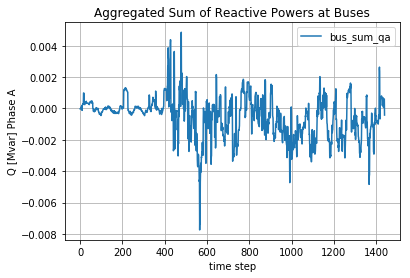

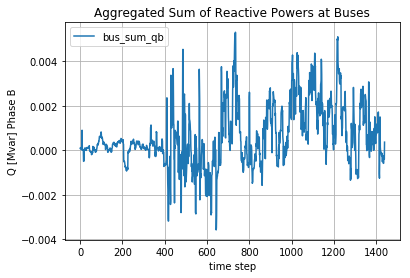

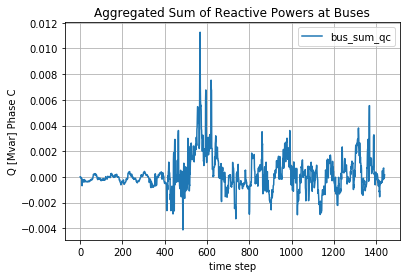

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# voltage results
vm_a_pu_file = os.path.join(output_dir, "res_bus_3ph", "vm_a_pu.xls")
vm_a_pu = pd.read_excel(vm_a_pu_file)
vm_a_pu.plot(label="vm_a_pu")
plt.xlabel("time step")
plt.ylabel("Phase A voltage mag. [p.u.]")
plt.title("Max. Voltage Magnitude Phase A")
plt.grid()
plt.show()

vm_b_pu_file = os.path.join(output_dir, "res_bus_3ph", "vm_b_pu.xls")
vm_b_pu = pd.read_excel(vm_b_pu_file)
vm_b_pu.plot(label="vm_b_pu")
plt.xlabel("time step")
plt.ylabel("Phase B voltage mag. [p.u.]")
plt.title("Max. Voltage Magnitude Phase B")
plt.grid()
plt.show()

vm_c_pu_file = os.path.join(output_dir, "res_bus_3ph", "vm_c_pu.xls")
vm_c_pu = pd.read_excel(vm_c_pu_file)
vm_c_pu.plot(label="vm_c_pu")
plt.xlabel("time step")
plt.ylabel("Phase C voltage mag. [p.u.]")
plt.title("Max. Voltage Magnitude Phase C")
plt.grid()
plt.show()
# p_mw results
p_a_mw_file = os.path.join(output_dir, "res_bus_3ph", "p_a_mw.xls")
p_b_mw_file = os.path.join(output_dir, "res_bus_3ph", "p_b_mw.xls")
p_c_mw_file = os.path.join(output_dir, "res_bus_3ph", "p_c_mw.xls")

p_a_mw = pd.read_excel(p_a_mw_file)
p_a_mw.plot(label="p_a_mw")
plt.xlabel("time step")
plt.ylabel("P [MW] Phase A")
plt.title("Aggregated Sum of Real Powers at Buses")
plt.grid()
plt.show()

p_b_mw = pd.read_excel(p_b_mw_file)
p_b_mw.plot(label="p_b_mw")
plt.xlabel("time step")
plt.ylabel("P [MW] Phase B")
plt.title("Aggregated Sum of Real Powers at Buses")
plt.grid()
plt.show()

p_c_mw = pd.read_excel(p_c_mw_file)
p_c_mw.plot(label="p_c_mw")
plt.xlabel("time step")
plt.ylabel("P [MW] Phase C")
plt.title("Aggregated Sum of Real Powers at Buses")
plt.grid()
plt.show()

# q_mvar results
q_a_mvar_file = os.path.join(output_dir, "res_bus_3ph", "q_a_mvar.xls")
q_b_mvar_file = os.path.join(output_dir, "res_bus_3ph", "q_b_mvar.xls")
q_c_mvar_file = os.path.join(output_dir, "res_bus_3ph", "q_c_mvar.xls")

q_a_mvar = pd.read_excel(q_a_mvar_file)
q_a_mvar.plot(label="q_a_mvar")
plt.xlabel("time step")
plt.ylabel("Q [Mvar] Phase A")
plt.title("Aggregated Sum of Reactive Powers at Buses")
plt.grid()
plt.show()

q_b_mvar = pd.read_excel(q_b_mvar_file)
q_b_mvar.plot(label="q_b_mvar")
plt.xlabel("time step")
plt.ylabel("Q [Mvar] Phase B")
plt.title("Aggregated Sum of Reactive Powers at Buses")
plt.grid()
plt.show()

q_c_mw = pd.read_excel(q_c_mvar_file)
q_c_mw.plot(label="q_c_mvar")
plt.xlabel("time step")
plt.ylabel("Q [Mvar] Phase C")
plt.title("Aggregated Sum of Reactive Powers at Buses")
plt.grid()
plt.show()